In [1]:
import numpy as np
import matplotlib.pylab as plt
import random as rn
import time
from scipy.spatial import ConvexHull
from matplotlib.patches import Rectangle
from matplotlib.path import Path
from mpl_toolkits.mplot3d import Axes3D
import shapely.geometry as geometry
import shapely.ops as so
from Dynamic import DynamicMap
from Camera import Camera
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import scipy.spatial as sp

In [2]:
# Position
map_size = [30, 30]
x0 = [2.5, 15, 0]
xf = [27.5, 15, 100]
# xf = [15, 17.5, 1000]
# static_obstacle_position: [anchor point, width, height]
static_obstacle_pos = [[[12.5, 10], 5, 10]]
dynamic_obstacle_pos = [[15, 10], [15, 20]]
prox = [2.5, 2.5] # [x, t]

# General RRT Settings
iter_max = 1000
tMax = 100
vmax = 10#2.5
max_time = 5

In [3]:
tilt_limit = np.array([[np.deg2rad(0), np.deg2rad(180)], [np.deg2rad(0), np.deg2rad(180)]]) #[upper, lower]
fov_ang = np.deg2rad(30)
fov_rng = 12
panSpeed = [-np.deg2rad(2.5), np.deg2rad(2.5)]

In [4]:
# Test case
# Vehicle Spec
vehicle = {}
vehicle['v'] = 2
vehicle['radius'] = 0.5
t = [200, .25, 500]

# Map
map_in = {}
# Static Map
map_in['st'] = {}
map_in['st']['size'] = np.array([0, map_size[0], 0, map_size[0]])
# Single buliding example
map_in['st']['n'] = 1
map_in['st']['0'] = np.array([(static_obstacle_pos[0][0][0],static_obstacle_pos[0][0][1]), 
                              (static_obstacle_pos[0][0][0],static_obstacle_pos[0][0][1]+static_obstacle_pos[0][2]), 
                                (static_obstacle_pos[0][0][0]+static_obstacle_pos[0][1],static_obstacle_pos[0][0][1]+static_obstacle_pos[0][2]), 
                                (static_obstacle_pos[0][0][0]+static_obstacle_pos[0][1],static_obstacle_pos[0][0][1])])

# Dynamic Map
# This is a continuous function generates camera FOV coverages
# Input is map_in, and time input t_in
map_in['n'] = t[0]

# Single camera example, surveying final location xfins
# Camera Position
cam_x = np.array([dynamic_obstacle_pos[0][0], dynamic_obstacle_pos[1][0]])
cam_y = np.array([dynamic_obstacle_pos[0][1], dynamic_obstacle_pos[1][1]])
cam_dict = {}
cam_dict['n'] = len(cam_x)
map_in['ncam'] = len(cam_x)
cam_dict['x'] = cam_x
cam_dict['y'] = cam_y

# Camera Spec
cam_period = t[0]
cam_increment = t[1]
cam_dict['spec'] = {}
cam_dict['spec']['init_angle'] = [np.deg2rad(90), np.deg2rad(-90)]
cam_dict['spec']['bound'] = tilt_limit
cam_dict['spec']['fov'] = [fov_ang, fov_rng]
cam_dict['spec']['cam_time'] = [cam_period, cam_increment]
cam_dict['spec']['panspeed'] = panSpeed

# Test dynamic map
dmap = DynamicMap(map_in, cam_dict)
map_in['dy'] = dmap

(0.0, 30.0)

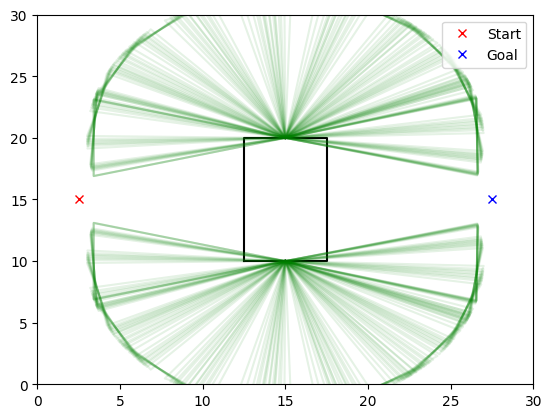

In [9]:
fig = plt.figure()
plt.plot(x0[0], x0[1], 'xr', label='Start')
plt.plot(xf[0], xf[1], 'xb', label='Goal')

building_alpha = 1
for ii in range(map_in['st']['n']):
    ibuilding = map_in['st'][str(ii)]
    wall = geometry.LineString(ibuilding)
    building = geometry.Polygon(wall)
    bx,by = building.exterior.xy
    plt.plot(bx, by, '-', color='k', alpha=building_alpha)

# Plot Cameras
dmap = map_in['dy']
tvec = np.linspace(0, 100, 101)
for t in tvec:
    for ii in range(2):
        cameras = dmap.gen_cam(ii, t)
        ncam = cameras['n']
        cam_i = cameras[str(ii)]['FOV_Poly']
        cx, cy = cam_i.exterior.xy
        plt.plot(cx, cy, '-g', alpha=0.1)
# plt.grid()
plt.legend(loc='upper right')
# Plot Limits
plt.xlim(0, map_size[0])
plt.ylim(0, map_size[1])

In [6]:
def distance(a, b):
    return np.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)

In [7]:
def random_sample_RRTC_parallel(qprev, tf, n, n2, k, sample_rate_vec):
    what_to_sample = rn.uniform(0, 1)
    
    # Find a random point in a domain
    if what_to_sample <= sample_rate_vec[0]:
        # Construct Points for Convex Hull
        point1 = [x0[0], x0[2]]
        point2 = [0, x0[0]/vmax]
        point3 = [map_size[0], (map_size[0]-x0[0])/vmax]
        point4 = [0, tf-xf[0]/vmax]
        point5 = [map_size[0], tf+xf[0]/vmax-map_size[0]/vmax]
        point6 = [xf[0], tf]
        pos = [point1, point2, point3, point4, point5, point6]

        # Convex hull
        hull = ConvexHull( pos )
        # Bounding box
        bbox = [hull.min_bound, hull.max_bound]
        #Hull path
        hull_path = Path(hull.points[hull.vertices])
        # Draw n
        rand_points = np.empty((n, 2))
        for i in range(n):
            rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])

            while hull_path.contains_point(rand_points[i]) == False:
                rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])
        xrand = rand_points[0][0]
        trand = rand_points[0][1]
        # yrand = rn.uniform(-vmax/2*(trand - 1/vmax*(xf[0]+x0[0])), vmax/2*(trand - 1/vmax*(xf[0]+x0[0])))
        yrand = rn.uniform(np.min([0, x0[0]/vmax]), np.min([vmax*(trand+x0[0]/vmax), map_size[1]]))
    else:
        if np.mod(k, n2) == 0:
            xrand = xf[0]
            yrand = xf[1]
            trand = tf
        else:
            xrand = x0[0]
            yrand = x0[1]
            trand = 0
    return [xrand, yrand, trand]

In [8]:
def reachable(q0, q1, forward=True):
    dx = np.abs(q1[0]-q0[0])
    dy = np.abs(q1[1]-q0[1])
    dd = np.sqrt(dx**2 + dy**2)
    dt = q1[2]-q0[2]

    if dd == 0:
        return True
    else:
        if forward and dt > 0 and dd/dt <= vmax:
            return True
        elif not forward and dt < 0 and dd/dt <= vmax:
            return True
        return False

In [9]:
def find_neighbor_RRTC_parallel(qrand, V, n, k):
    # Find neighbor
    dist_vec = []
    if np.mod(k,n) == 0:
        forward = True
    else:
        forward = False

    for i in range(len(V)):
        if reachable(V[i], qrand, forward):
            dist_vec.append(np.abs(distance(V[i], qrand)))
        else:
            dist_vec.append(1e100)
    if len(dist_vec) > 0:
        closest = dist_vec.index(min(dist_vec))
        qclosest = V[closest]
        return qclosest
    else:
        return None

In [10]:
def extend_WG(qclosest, q1, max_time):
    dx = q1[0]-qclosest[0]
    dy = q1[1]-qclosest[1]
    dt = q1[2]-qclosest[2]
    max_distance = max_time

    if np.abs(dx) <= max_distance and np.abs(dy) <= max_distance and np.abs(dt) <= max_time:
        qnew = q1
    else:
        norm = np.sqrt(dx**2+dy**2+dt**2)
        dxnorm = dx/norm*max_distance
        dynorm = dy/norm*max_distance
        dtnorm = dt/norm*max_distance
        qnew = [qclosest[0]+dxnorm, qclosest[1]+dxnorm, qclosest[2]+dtnorm]
    return qnew

In [11]:
def validate(q):
    # True:  No violation
    # False: Violation detected
    tGiven = q[2]
    qpoint = Point(q[0], q[1])

    checkInMap = []
    # Check for map
    # Check if x coordinate is OK
    if q[0] >= 0 and q[0] <= map_size[0]:
        # Check if y coordinate is OK
        if q[1] >= 0 and q[1] <= map_size[1]:
            checkInMap = True
        else:
            checkInMap = False
    else:
        checkInMap = False
    
    checkStatic = []
    # Check for static
    for i in range(len(static_obstacle_pos)):
        static_polygon = Polygon(map_in['st'][str(i)])
        checkStatic.append(not static_polygon.contains(qpoint))

    checkDynamic = []
    # Check for dynamic
    for i in range(cam_dict['n']):
        cameras = dmap.gen_cam(i, tGiven)
        cam_i = cameras[str(i)]['FOV_Poly']
        checkDynamic.append(not cam_i.contains(geometry.Point(q[0],q[1])))

    return bool(bool(checkInMap) and bool(np.sum(checkStatic)) and bool(np.sum(checkDynamic)))

In [12]:
def check_route(q1, q2):
    line = geometry.LineString([q1, q2])

    checkStatic = []
    #check for static
    # False: No collision
    for i in range(len(static_obstacle_pos)):
        static_polygon = Polygon(map_in['st'][str(i)])
        checkStatic.append(line.intersects(static_polygon))

    checkDynamic = []
    # check for dynamic
    # False: No collision
    timeVectorToCheck = np.linspace(q1[2], q2[2], 101)
    for tGiven in timeVectorToCheck:
        for i in range(cam_dict['n']):
            # TODO
            # get FOV and check geometric containment
            cameras = dmap.gen_cam(i, tGiven)
            cam_i = cameras[str(i)]['FOV_Poly']
            checkDynamic.append(line.intersects(cam_i))
    # True: No collision
    # False: Collison
    if not(bool(np.sum(checkStatic))) and not(bool(np.sum(checkDynamic))):
        # Collison-free
        return True
    else:
        return False

In [13]:
def find_path_parallel(vi, vf, V, E, trigger):
    # trigger:
    # 0 -> a
    # 1 -> b
    path_vec = []
    path_vec.append(vf)
    curr = vf
    kek = 0
    # print('start: ',curr)
    while 1:
        for ei in range(len(E)):
            e = E[ei][1]            
            # print('e: ', e)
            # print('Edge: ', E[ei], ei)
            if np.abs(curr[0]-e[0]) <1e-4 and np.abs(curr[1]-e[1])<1e-4 and np.abs(curr[2]-e[2])<1e-4:
                # print('Edge: ', E[ei], ei)
                if trigger == 0:
                    curr = E[ei][0]
                else:
                    curr = E[ei][0]
                path_vec.append(curr)
                break        
        kek += 1

        if trigger == 0:
            if curr[0] == vi[0] and curr[1] == vi[1] and curr[2] == vi[2]:
                return path_vec
        elif trigger == 1:
            if np.abs(curr[0]-vi[0]) <= 0.01 and \
                np.abs(curr[1]-vi[1]) <= 0.01 and \
                    np.abs(curr[2]-vi[2]) <= 0.01:
                return path_vec
            

In [14]:
# Standard RRT with Parallel
def standard_RRTC_Parallel(n, compTimeLimit, tf0, tfn, sample_rate_vec=[0.9, 0.1]):
    total_path_time = 0
    max_time = 5
    total_path_distance = 0
    tfSelection = []
    for ii in range(n):
        tfSelection.append(rn.uniform(tf0, tfn))
    qprev_start = [x0, 0]
    qprev_goal = [xf, tfSelection[0]]
    k = 0
    V_RRTCa = []
    V_RRTCa.append([x0[0], x0[1], 0])
    V_RRTCb = {}
    T_RRTCb = {}
    E_RRTCb = {}
    for ii in range(n):
        V_RRTCb[str(ii)] = []
        V_RRTCb[str(ii)].append([xf[0], xf[1], tfSelection[ii]])
        T_RRTCb[str(ii)] = []
        T_RRTCb[str(ii)].append(tfSelection[ii])
        E_RRTCb[str(ii)] = []
    T_RRTCa = []
    T_RRTCa.append(0)
    E_RRTCa = []

    final_path = None
    path_check = False
    start = time.time()
    while 1:
        # print(time.time()-start)
        for ii in range(n):
            print('k: ', k)
            # print('tf: '+ str(tfSelection[ii])+' k: '+str(k))
            while 1:
                # print('tf: '+ str(tfSelection[ii])+' k: '+str(k))

                if (time.time()-start) > (compTimeLimit):
                    break
                # Sample
                if np.mod(k, n) == 0:
                    qrand = random_sample_RRTC_parallel(qprev_start, tfSelection[ii], 1, n, k, sample_rate_vec)
                else:
                    qrand = random_sample_RRTC_parallel(qprev_goal, tfSelection[ii], 1, n, k, sample_rate_vec)

                if np.mod(k, n) == 0:
                    qclosest = find_neighbor_RRTC_parallel(qrand, V_RRTCa, n, k)
                else:
                    qclosest = find_neighbor_RRTC_parallel(qrand, V_RRTCb[str(ii)], n, k)
                if (time.time()-start) > (compTimeLimit):
                    break

                if qclosest is not None:
                    qnew = extend_WG(qclosest, qrand, max_time)
                    # Validate: True-> good
                    valid = validate(qnew)
                    if valid and check_route(qclosest, qnew):
                            break
            # print(time.time()-start)
            if (time.time()-start) > (compTimeLimit):
                break
            # Add V, E
            if np.mod(k, n) == 0:
                V_RRTCa.append(qnew)
                E_RRTCa.append([qclosest, qnew])
                T_RRTCa.append(qnew[2])
                qprev_start = qnew
            else:
                V_RRTCb[str(ii)].append(qnew)
                E_RRTCb[str(ii)].append([qclosest, qnew])
                T_RRTCb[str(ii)].append(qnew[2])
                qprev_goal = qnew
            if (time.time()-start) > (compTimeLimit):
                break
            # Check continue
            if np.mod(k,n) == 0:
                for vj in V_RRTCb[str(ii)]:
                    if reachable(V_RRTCa[-1], vj, forward=True):
                        if check_route(V_RRTCa[-1], vj) and reachable(V_RRTCa[-1], vj):# and np.abs(V_RRTCa[-1][1]-vj[1]) <= 5 
                            connect_edge = [V_RRTCa[-1], vj]
                            path_check = True
                            break
            else:
                for vi in V_RRTCa:
                    if reachable(vi, V_RRTCb[str(ii)][-1], forward=False):
                        if check_route(vi, V_RRTCb[str(ii)][-1]) and reachable(vi, V_RRTCb[str(ii)][-1]):#and np.abs(V_RRTCb[-1][1]-vi[1]) <= 5 
                            connect_edge = [vi, V_RRTCb[str(ii)][-1]]
                            path_check = True
                            break
            if path_check:
                break
            k += 1

        # print(time.time()-start)
        if (time.time()-start) > (compTimeLimit):
            break
        if path_check:
            E_RRTC = E_RRTCa + E_RRTCb[str(ii)]
            E_RRTC.append(connect_edge)
            # return True, 0, 0, 0, 1, None, V_RRTCa, V_RRTCb, E_RRTCa, E_RRTCb
            patha = find_path_parallel([x0[0], x0[1], 0], connect_edge[0], V_RRTCa, E_RRTCa, 0)
            pathb = find_path_parallel([xf[0], xf[1], tfSelection[ii]], connect_edge[1], V_RRTCb[str(ii)], E_RRTCb[str(ii)], 1)
            final_path = list(reversed(patha)) + pathb                
            for fpv in range(len(final_path)-1):
                total_path_time += (final_path[fpv+1][1]-final_path[fpv][1])
                total_path_distance += np.abs(final_path[fpv+1][0]-final_path[fpv][0])
            break
        # print(time.time()-start)
        if time.time()-start > compTimeLimit:
            break
    end = time.time()
    
    if path_check:
        return True, end-start, total_path_distance, total_path_time, 1, final_path, V_RRTCa, V_RRTCb, E_RRTCa, E_RRTCb
    else:
        return False, end-start, total_path_distance, total_path_time, 0, None, V_RRTCa, V_RRTCb, E_RRTCa, E_RRTCb


In [19]:
nPartition = 10
compTimeLimit = 600
tfmin = 10
tfmax = 100

pathFoundRRTP, compTime, total_path_distance, total_path_time, successPath, final_path, V_RRTPa, V_RRTPb, E_RRTPa, E_RRTPb = standard_RRTC_Parallel(nPartition, compTimeLimit, tfmin, tfmax)
print(pathFoundRRTP)

k:  0
k:  1
k:  2
k:  3
k:  4
k:  5
k:  6
k:  7
k:  8
k:  9
k:  10
k:  11
k:  12
k:  13
k:  14
k:  15
k:  16
k:  17
k:  18
k:  19
k:  20
k:  21
k:  22
k:  23
k:  24
k:  25
k:  26
k:  27
k:  28
k:  29
k:  30
k:  31
k:  32
k:  33
k:  34
k:  35
k:  36
k:  37
k:  38
k:  39
k:  40
k:  41
k:  42
k:  43
k:  44
k:  45
k:  46
k:  47
k:  48
k:  49
k:  50
k:  51
k:  52
k:  53
k:  54
k:  55
k:  56
k:  57
k:  58
k:  59
k:  60
k:  61
k:  62
k:  63
k:  64
k:  65
k:  66
k:  67
k:  68
k:  69
k:  70
k:  71
k:  72
k:  73
k:  74
k:  75
k:  76
k:  77
k:  78
k:  79
k:  80
k:  81
k:  82
k:  83
k:  84
k:  85
k:  86
k:  87
k:  88
k:  89
k:  90
k:  91
k:  92
k:  93
k:  94
k:  95
k:  96
k:  97
k:  98
k:  99
k:  100
k:  101
k:  102
k:  103
k:  104
k:  105
k:  106
k:  107
k:  108
k:  109
k:  110
k:  111
k:  112
k:  113
k:  114
k:  115
k:  116
k:  117
k:  118
k:  119
k:  120
k:  121
k:  122
k:  123
k:  124
k:  125
k:  126
k:  127
k:  128
k:  129
k:  130
k:  131
k:  132
k:  133
k:  134
k:  135
k:  136
k:  137
k:  13

KeyboardInterrupt: 

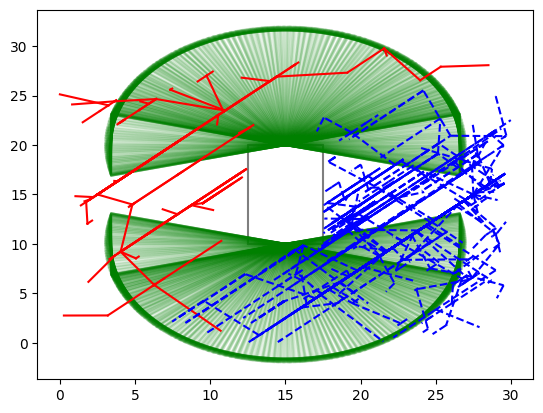

In [18]:
fig = plt.figure()

building_alpha = 0.5
for ii in range(map_in['st']['n']):
    ibuilding = map_in['st'][str(ii)]
    wall = geometry.LineString(ibuilding)
    building = geometry.Polygon(wall)
    bx,by = building.exterior.xy
    plt.plot(bx, by, '-', color='k', alpha=building_alpha)

# Plot Cameras
dmap = map_in['dy']
time_index = np.linspace(0, tfmax, 501)
for t in time_index:
    for ii in range(2):
        cameras = dmap.gen_cam(ii, t)
        ncam = cameras['n']
        cam_i = cameras[str(ii)]['FOV_Poly']
        cx, cy = cam_i.exterior.xy
        plt.plot(cx, cy, '-g', alpha=0.1)

for E in E_RRTPa:
    plt.plot([E[0][0], E[1][0]], [E[0][1], E[1][1]], '-r')
for ii in range(nPartition):
    for E in E_RRTPb[str(ii)]:
        plt.plot([E[0][0], E[1][0]], [E[0][1], E[1][1]], '--b')

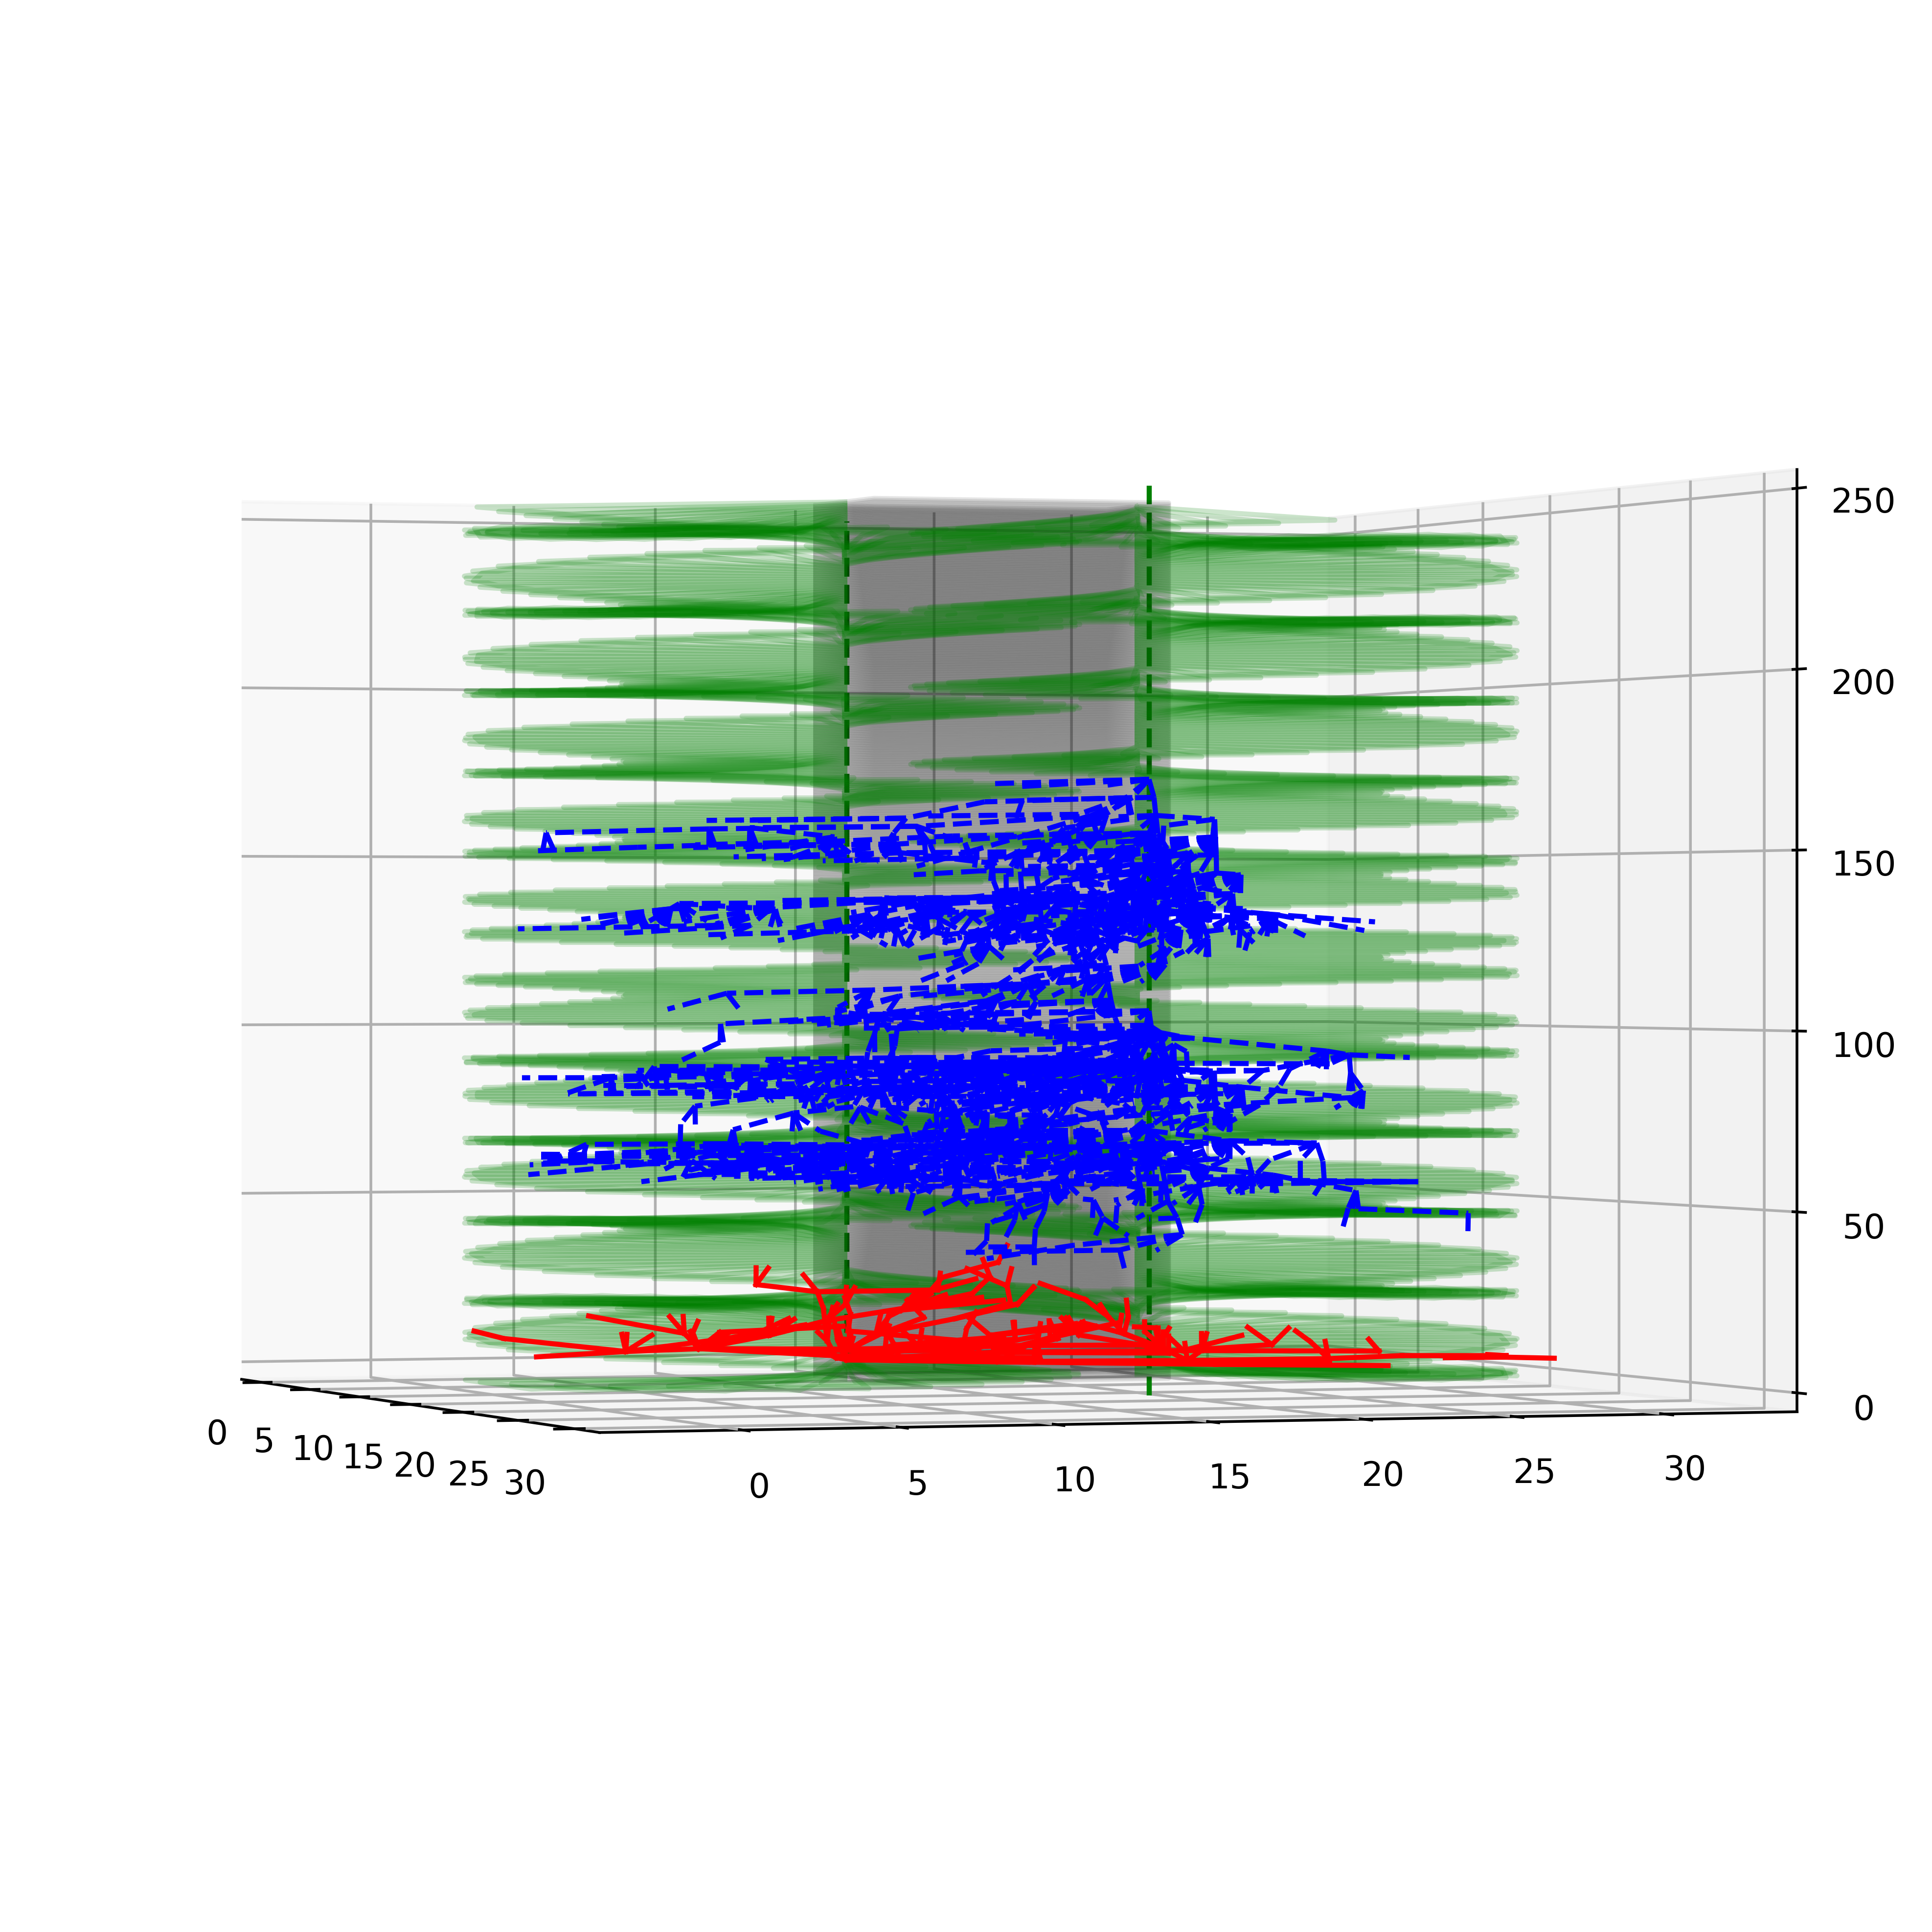

In [17]:
fig = plt.figure(figsize=(10, 10), dpi=500)
ax = fig.add_subplot(111, projection='3d')
ax.plot3D([x0[0], x0[0]], [x0[1], x0[1]], [0, 250], '--g', markersize=5)
ax.plot3D([xf[0], xf[0]], [xf[1], xf[1]], [0, 250], '--g', markersize=5)

building_alpha = 0.1
for ti in time_index:
    for ii in range(map_in['st']['n']):
        ibuilding = map_in['st'][str(ii)]
        wall = geometry.LineString(ibuilding)
        building = geometry.Polygon(wall)
        bx,by = building.exterior.xy
        ax.plot3D(bx, by, np.ones(len(bx))*ti, '-', color='k', alpha=building_alpha)

# Plot Cameras
dmap = map_in['dy']
for ti in time_index:
    for ii in range(2):
        cameras = dmap.gen_cam(ii, ti)
        ncam = cameras['n']
        cam_i = cameras[str(ii)]['FOV_Poly']
        cx, cy = cam_i.exterior.xy
        ax.plot3D(cx, cy, np.ones(len(cx))*ti, '-g', alpha=.2)


for E in E_RRTPa:
    plt.plot([E[0][0], E[1][0]], [E[0][1], E[1][1]], [E[0][2], E[1][2]], '-r')
for ii in range(nPartition):
    for E in E_RRTPb[str(ii)]:
        plt.plot([E[0][0], E[1][0]], [E[0][1], E[1][1]], [E[0][2], E[1][2]], '--b')
        
ax.view_init(elev=0., azim=-20)
